In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from osgeo import gdal
from osgeo import gdalconst
from osgeo import osr
import subprocess
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import crs
import geopandas as gpd
import pandas as pd
import geemap
import ee
import rioxarray as rxr
from rio_cogeo.profiles import cog_profiles
import geowombat as gw
import json
import shapely.geometry

In [ ]:
ee.Authenticate()

In [2]:
ee.Initialize()

In [6]:
bathpath = os.path.join(os.getcwd(),'data\\spatial\\rasters')  

In [8]:
files_to_mosaic = glob.glob(bathpath +'//*.tif')
files_to_mosaic

['C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\GBlidar1.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\GBlidar2.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\GBlidar3.tif']

In [90]:
proj = osr.SpatialReference()
proj.ImportFromEPSG(32750)
print(proj)

PROJCS["WGS 84 / UTM zone 50S",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",117],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",10000000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32750"]]


In [91]:
for x in files_to_mosaic:
    ras = gdal.Open(x, gdal.GA_Update)
    ras.SetProjection(proj.ExportToWkt())
    del ras # save, close

In [95]:
outproj = os.path.join(os.getcwd(),'data\\spatial\\rasters\\SDB Test data\\Proj')  

In [ ]:
xres=10
yres=10
NODATA_VALUE = -3.4e+38
#'EPSG:32750'
#srcSRS = 'EPSG:4326'
for x, index  in enumerate (files_to_mosaic):
    #print(x, index)
    res = (
            gdal.Warp(outproj + '\\GBLidar' + str(x+1) +'.tif' , srcSRS = 'EPSG:32750', index,
                 #format = 'GTiff',
                 dstSRS = 'EPSG:32750',srcNodata = NODATA_VALUE, dstNodata = NODATA_VALUE,
                 xRes=xres, yRes=yres, resampleAlg=gdalconst.GRA_Cubic)
        )
    #res = None
    del res # save, close

In [42]:
outmos = os.path.join(os.getcwd(),'data\\spatial\\rasters\\SDB Test data\\Mosaic\\5m.tif')  

In [43]:
outmos

'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\Mosaic\\5m.tif'

In [98]:
xres=10
yres=10
NODATA_VALUE = -3.4e+38
#'EPSG:32750'
res = (
        gdal.Warp(outmos, files_to_mosaic, srcSRS = 'EPSG:32750',
                 dstSRS = 'EPSG:32750',srcNodata = NODATA_VALUE, dstNodata = NODATA_VALUE ,
                 xRes=xres, yRes=yres, resampleAlg=gdalconst.GRA_Cubic)
        )
res = None

In [68]:
#del res

In [79]:
outreproj = os.path.join(os.getcwd(),'data\\spatial\\rasters\\SDB Test data\\Mosaic\\5m_reproj.tif')  

In [80]:
xres=10
yres=10
NODATA_VALUE = -3.4e+38
#'EPSG:32750'
res = (
        gdal.Warp(outreproj, outmos, srcSRS = 'EPSG:32750',
                 dstSRS = 'EPSG:32750',srcNodata = NODATA_VALUE, dstNodata = NODATA_VALUE ,
                 xRes=xres, yRes=yres, resampleAlg=gdalconst.GRA_Cubic)
        )
res = None

In [99]:
bath = rasterio.open(outmos)

In [100]:
print(bath.crs)
print(bath.bounds)

EPSG:32750
BoundingBox(left=306995.0, bottom=6274000.0, right=387005.0, top=6324010.0)


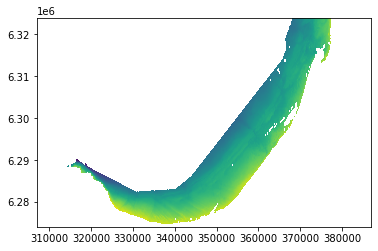

<AxesSubplot:>

In [101]:
show(bath)

In [69]:
del(bath)

In [108]:
bath.indexes
band1 = np.array(bath.read(1))
band1

array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [105]:
np.set_printoptions(suppress=True)

In [106]:
print(band1.min(), band1.max())

-3.4e+38 -0.01


In [119]:
path_to = outmos
out_cog = r'C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\COG\COG.tif'

In [120]:
geemap.image_to_cog(path_to, out_cog)

Reading input: C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\Mosaic\5m.tif

Adding overviews...
Updating dataset tags...
Writing output to: C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\COG\COG.tif


In [121]:
geemap.cog_validate(out_cog, verbose=True)

Info(Path='C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\COG\\COG.tif', Driver='GTiff', COG=True, Compression='DEFLATE', ColorSpace=None, COG_errors=None, COG_warnings=None, Profile=Profile(Bands=1, Width=8001, Height=5001, Tiled=True, Dtype='float32', Interleave='BAND', AlphaBand=False, InternalMask=False, Nodata=-3.3999999521443642e+38, ColorInterp=('gray',), ColorMap=False, Scales=(1.0,), Offsets=(0.0,)), GEO=Geo(CRS='EPSG:32750', BoundingBox=(306995.0, 6274000.0, 387005.0, 6324010.0), Origin=(306995.0, 6324010.0), Resolution=(10.0, -10.0), MinZoom=9, MaxZoom=14), Tags={'Image Metadata': {'AREA_OR_POINT': 'Area', 'OVR_RESAMPLING_ALG': 'NEAREST'}, 'Image Structure': {'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND', 'LAYOUT': 'COG'}}, Band_Metadata={'Band 1': BandMetadata(Description=None, ColorInterp='gray', Offset=0.0, Scale=1.0, Metadata={})}, IFD=[IFD(Level=0, Width=8001, Height=5001, Blocksize=(512, 512), Decimation=0), IFD

In [122]:
bath_cog = rasterio.open(out_cog)

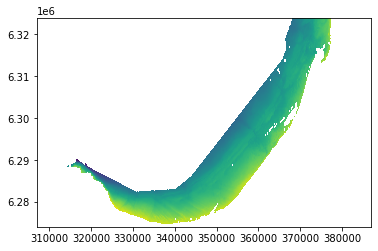

<AxesSubplot:>

In [123]:
show(bath_cog)

In [124]:
URL = 'https://storage.cloud.google.com/cog-bucket/GB_COG.tif'

In [125]:
bathy_ee = geemap.load_GeoTIFF(URL)

In [126]:
bathy_ee

In [127]:
im_stats = geemap.image_stats(bathy_ee, scale=10)
im_stats.getInfo()

{'max': {'B0': -0.009999999776482582},
 'mean': {'B0': -14.653905649874314},
 'min': {'B0': -38.04999923706055},
 'std': {'B0': 6.0051612847694},
 'sum': {'B0': -111866611.5335377}}

In [213]:
bath_vis = {'bands': ['B0'], 'min': -38.0499, 'max': -0.009, 'palette': ['red','orange','yellow', 'green']}

Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.add_basemap('HYBRID')
Map.addLayer(bathy_ee,bath_vis, 'Bathy')
Map.centerObject(bathy_ee.geometry(), 12)
Map

Map(center=[-33.43743969273598, 115.35413081830664], controls=(WidgetControl(options=['position', 'transparent…

In [214]:
def maskS2clouds(image):
    cloud_mask = image.select('QA60').bitwiseAnd(int('11111', 10)).eq(0) 
    snow_mask  =  image.select('QA60').bitwiseAnd(int('11111', 11)).eq(0)
    shadow_mask = image.select('QA60').bitwiseAnd(int('11111', 3)).eq(0)

    opticalBands = image.select('B.').multiply(0.0001)
    return (image.addBands(opticalBands, None, True) 
                .updateMask(cloud_mask)  
                .updateMask(snow_mask) 
                .updateMask(shadow_mask)  
           )
 

In [216]:
#Bounding box, ru nafter adding bbox
Map.draw_features
bound = ee.FeatureCollection(Map.draw_features)
Map.addLayer(bound, {}, 'bound')
Map.remove_drawn_features()

In [215]:
start_date = '2020-03-01'
end_date = '2022-06-30'

In [217]:
S2 = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterBounds(bound)
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
    .filterDate(start_date, end_date)
    .map(maskS2clouds)
    .median()
    .clip(bound)    
)

In [218]:
proj = ee.Projection('EPSG:32750')
S2 = S2.reproject(proj, None, 10)

In [219]:
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.2}
Map.addLayer(S2, vis_params, 'Sentinel-2 image')

In [171]:
#bound = S2.geometry()

In [222]:
ndwi_image = S2.normalizedDifference(['B3', 'B5'])

In [223]:
vis_ndwi = {
    'min': -1,
    'max': 1,
    'palette': [
        '#ece7f2',
        '#d0d1e6',
        '#a6bddb',
        '#74a9cf',
        '#3690c0',
        '#0570b0',
        '#045a8d',
        '#023858',
    ],
}
Map.addLayer(ndwi_image, vis_ndwi, 'NDWI image')

In [237]:
ndwi_threshold = 0
water_image = ndwi_image.gt(ndwi_threshold).selfMask().clip(bound)
Map.addLayer(water_image, {}, 'Water image')

In [ ]:
water_vector = water_image.reduceToVectors(scale=100, maxPixels=100000000)
Map.addLayer(water_vector, {}, 'Water vector')

In [ ]:
#Map.addLayer(s2_bound, {}, 'bound')

In [226]:
#draw glintbounds
Map_glint = geemap.Map(zoom=4, toolbar_ctrl=True, layer_ctrl=True)
Map_glint.add_basemap('HYBRID')
Map_glint.add_minimap(zoom=6)
Map_glint.centerObject(bound, 12)
Map_glint.addLayer(S2, vis_params, 'Sentinel-2')
#Map_glint.addLayer(S2, vis_toa, 'Sentinel-2 BOA')
Map_glint


Map(center=[-33.440198013878586, 115.34745881013788], controls=(WidgetControl(options=['position', 'transparen…

In [196]:
#S2 = S2.clip(water_vector)

In [227]:
Map_glint.draw_features
glint = ee.FeatureCollection(Map_glint.draw_features)
Map_glint.addLayer(glint, {}, 'Glint')
Map_glint.remove_drawn_features()

In [228]:
B2_sr = S2.select(['B8', 'B2'])
B3_sr = S2.select(['B8', 'B3'])
B4_sr = S2.select(['B8', 'B4'])

In [229]:
lfitB2_sr = B2_sr.reduceRegion(
              reducer=ee.Reducer.linearFit(),
              geometry=glint,
              scale=10,
              #crs = 'EPSG:7844',
              #maxPixels =  1000,
              bestEffort = True)

lfitB3_sr = B3_sr.reduceRegion(
              reducer=ee.Reducer.linearFit(),
              geometry=glint,
              scale=10,
              #crs = 'EPSG:7844',
              #maxPixels =  1000,
              bestEffort = True)

lfitB4_sr = B3_sr.reduceRegion(
              reducer=ee.Reducer.linearFit(),
              geometry=glint,
              scale=10,
              #crs = 'EPSG:7844',
              #maxPixels =  1000,
              bestEffort = True)


In [239]:
slope_B2_sr = ee.Image.constant(lfitB2_sr.get('scale')).clip(bound).rename('slope_B2')
slope_B3_sr = ee.Image.constant(lfitB3_sr.get('scale')).clip(bound).rename('slope_B3')
slope_B4_sr = ee.Image.constant(lfitB4_sr.get('scale')).clip(bound).rename('slope_B4')
min_B8_sr = ee.Image.constant(S2.select('B8').reduceRegion(ee.Reducer.min(),bound).get('B8')).rename('min_B8')

In [240]:
glint_factors_sr = ee.Image([slope_B2_sr, slope_B3_sr, slope_B4_sr, min_B8_sr])
S2_add = S2.addBands(glint_factors_sr)

In [241]:
deglint_B2_sr = S2_add.expression(
    'Blue - (Slope * (NIR - MinNIR))', {
    'Blue': S2_add.select('B2'),
    'NIR': S2_add.select('B8'),
    'MinNIR': S2_add.select('min_B8'),
    'Slope': S2_add.select('slope_B2')
}).rename('B2')

deglint_B3_sr = S2_add.expression(
    'Green - (Slope * (NIR - MinNIR))', {
    'Green': S2_add.select('B3'),
    'NIR': S2_add.select('B8'),
    'MinNIR': S2_add.select('min_B8'),
    'Slope': S2_add.select('slope_B3')
}).rename('B3')

deglint_B4_sr = S2_add.expression(
    'Red - (Slope * (NIR - MinNIR))', {
    'Red': S2_add.select('B4'),
    'NIR': S2_add.select('B8'),
    'MinNIR': S2_add.select('min_B8'),
    'Slope': S2_add.select('slope_B4')
}).rename('B4')


In [242]:
S2_deglint_sr = ee.Image([deglint_B2_sr, deglint_B3_sr, deglint_B4_sr])

In [243]:
Map.addLayer(S2_deglint_sr, vis_params, 'Deglint')

In [245]:
vis_rgb = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.2}
split_sr = geemap.Map(zoom=15)
left_layer_sr = geemap.ee_tile_layer(S2, vis_rgb, name='S2')
right_layer_sr = geemap.ee_tile_layer(S2_deglint_sr, vis_rgb, name='Deglint')
split_sr.split_map(left_layer_sr, right_layer_sr)
split_sr

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [246]:
Map_bath = geemap.Map(zoom=4, toolbar_ctrl=True, layer_ctrl=True)
Map_bath.add_basemap('HYBRID')
Map_bath.add_minimap(zoom=6)
Map_bath.centerObject(bound.geometry(), 12)
Map_bath.addLayer(S2_deglint_sr, vis_params, 'S2 deglint')
Map_bath.addLayer(bathy_ee,bath_vis, 'Bathy')
Map_bath.addLayer(bound,{}, 'Bound')
Map_bath

Map(center=[-33.440198013878586, 115.34745881013788], controls=(WidgetControl(options=['position', 'transparen…

In [247]:
S2_deglint_sr_log = (
                    S2_deglint_sr
                    .log()
                    )

In [248]:
S2_deglint_sr_add = S2_deglint_sr_log.addBands(bathy_ee)

In [249]:
Map_bath.draw_features
bath_dat = ee.FeatureCollection(Map_bath.draw_features)
Map_bath.addLayer(bath_dat, {}, 'bath poly')
Map_bath.remove_drawn_features()

In [291]:
geemap.ee_to_shp(bath_dat, filename=r'C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\SDB\Test Polys\Test_pols.shp')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\SDB\Test Polys\Test_pols.shp


In [250]:
constant = ee.Image(1)
xVar = S2_deglint_sr_add.select(['B2' , 'B3'])
yVar = S2_deglint_sr_add.select('B0')

imgRegress = ee.Image.cat(constant, xVar, yVar)

In [251]:
im_stats = geemap.image_stats(imgRegress, region = bath_dat, scale=10)
im_stats.getInfo()

{'max': {'B0': -5.840000152587891,
  'B2': -2.4672767118602947,
  'B3': -2.7366951971666484,
  'constant': 1},
 'mean': {'B0': -15.723884419626756,
  'B2': -3.2804643492150842,
  'B3': -3.4866517976770575,
  'constant': 1},
 'min': {'B0': -35.810001373291016,
  'B2': -3.548363378699692,
  'B3': -4.010420592745215,
  'constant': 1},
 'std': {'B0': 4.00481733371197,
  'B2': 0.11307816661693082,
  'B3': 0.15177751444611098,
  'constant': 0},
 'sum': {'B0': -4830993.916627774,
  'B2': -1007961.0977552054,
  'B3': -1071314.6065183177,
  'constant': 307261.7137254913}}

In [252]:
linearRegression = imgRegress.reduceRegion(
                   reducer = ee.Reducer.linearRegression(numX= 3, numY= 1),
                   geometry = bath_dat,
                   scale= 10
                  )


In [253]:
coefList = ee.Array(linearRegression.get('coefficients')).toList()

In [254]:
b0 = ee.List(coefList.get(0)).get(0).getInfo()
b1 = ee.List(coefList.get(1)).get(0).getInfo()
b2 = ee.List(coefList.get(2)).get(0).getInfo()

print('OLS estimates', linearRegression.getInfo())
print('y-intercept:', b0)
print('Slope:', b1)
print('Slope:', b2)

OLS estimates {'coefficients': [[0.5593856475591905], [-20.668242557119786], [24.115127494125073]], 'residuals': [2.788052240273139]}
y-intercept: 0.5593856475490829
Slope: -20.668242557123037
Slope: 24.11512749412605


In [255]:
b0_int = ee.Image(b0).clip(bound).rename('Intercept')
b2_s = ee.Image(b1).clip(bound).rename('B2 Slope')
b3_s = ee.Image(b2).clip(bound).rename('B3 Slope')
b2 = ee.Image(S2_deglint_sr_add.select('B2')).clip(bound).rename('B2')
b3 = ee.Image(S2_deglint_sr_add.select('B3')).clip(bound).rename('B3')

In [256]:
bath_factors = ee.Image.cat(b0_int, b2_s, b3_s, b2, b3)
#S2_deglint_sr_add.addBands(bath_factors)

In [257]:
print(bath_factors.geometry().getInfo())
print(S2_deglint_sr_add.geometry().getInfo())

{'type': 'Polygon', 'coordinates': [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]}
{'type': 'Polygon', 'coordinates': [[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]]}


In [ ]:
im_stats = geemap.image_stats(bath_factors, region = bound, scale=10)
im_stats.getInfo()

In [258]:
SDB = bath_factors.expression(
    'Intercept + (B2_Slope * Blue) + (B3_Slope * Red)', {
    'Blue': bath_factors.select('B2'),
    'Red': bath_factors.select('B3'),
    'B2_Slope': bath_factors.select('B2 Slope'),
    'B3_Slope': bath_factors.select('B3 Slope'),
    'Intercept' : bath_factors.select('Intercept')
}).rename('SBD')


In [ ]:
im_stats = geemap.image_stats(SDB, region = bound, scale=10)
im_stats.getInfo()

In [260]:
sdb_vis = { 'min': -50, 'max': 3.5, 'palette': ['red','orange','yellow', 'green']}

Map_sdb = geemap.Map(zoom=4, toolbar_ctrl=True, layer_ctrl=True)
Map_sdb.add_basemap('HYBRID')
Map_sdb.add_minimap(zoom=6)
Map_sdb.centerObject(bound.geometry(), 12)
#Map_bath.addLayer(S2_deglint_sr, vis_params, 'S2 deglint')
Map_sdb.addLayer(bathy_ee,bath_vis, 'Bathy')
Map_sdb.addLayer(SDB,sdb_vis, 'SDB')
Map_sdb.addLayer(S2_deglint_sr, vis_params, 'S2 deglint')
#Map_bath.addLayer(bound,{}, 'Bound')
#Map_glint.addLayer(S2, vis_toa, 'Sentinel-2 BOA')
Map_sdb


Map(center=[-33.440198013878586, 115.34745881013788], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
Map_sdb.addLayer(SDB, vis_sdb, 'fit')

In [266]:
fishnet = geemap.fishnet(bound, h_interval=0.3, v_interval=0.3, delta=1)

In [269]:
out_dir = os.path.join(os.getcwd(), 'data\\spatial\\rasters\\SDB Test data\\SDB')

In [270]:
out_dir

'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB'

In [271]:
geemap.download_ee_image_tiles(
    SDB, fishnet,out_dir, prefix="SDB_", crs="EPSG:32750", scale=10, overwrite=True
)

SDB_1.tif: |                                                          | 0.00/77.0M (raw) [  0.0%] in 00:00 (et…

SDB_2.tif: |                                                          | 0.00/76.5M (raw) [  0.0%] in 00:00 (et…

SDB_3.tif: |                                                          | 0.00/76.1M (raw) [  0.0%] in 00:00 (et…

SDB_4.tif: |                                                          | 0.00/77.2M (raw) [  0.0%] in 00:00 (et…

SDB_5.tif: |                                                          | 0.00/76.8M (raw) [  0.0%] in 00:00 (et…

SDB_6.tif: |                                                          | 0.00/76.3M (raw) [  0.0%] in 00:00 (et…

In [275]:
out_dir_tiles = os.path.join(os.getcwd(), 'data\\spatial\\rasters\\SDB Test data\\SDB') 

In [276]:
out_dir_tiles

'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB'

In [277]:
bath_to_mosaic = glob.glob(out_dir_tiles +'//*.tif')
bath_to_mosaic

['C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_1.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_2.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_3.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_4.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_5.tif',
 'C:\\Users\\00097030\\LocalData\\Git\\Notebooks\\parks-geographe\\data\\spatial\\rasters\\SDB Test data\\SDB\\SDB_6.tif']

In [15]:
bathmos = os.path.join(os.getcwd(),'data\\spatial\\rasters\\SDB Test data\\SDB\\Mosaic\\SDB_mos.tif')  

In [288]:
xres=10
yres=10
NODATA_VALUE = -9999
#'EPSG:32750'
res = (
        gdal.Warp(bathmos, bath_to_mosaic, srcSRS = 'EPSG:32750', dstNodata = NODATA_VALUE,
                 dstSRS = 'EPSG:32750' ,
                 xRes=xres, yRes=yres, resampleAlg=gdalconst.GRA_Cubic)
        )
res = None

In [4]:
SDB_mos = rasterio.open(bathmos)

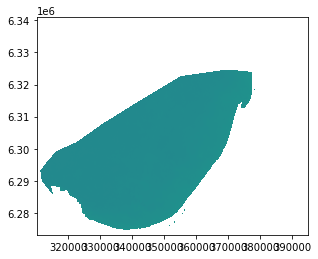

<AxesSubplot:>

In [5]:
show(SDB_mos)

In [3]:
shapefile = gpd.read_file(r"C:\Users\00097030\LocalData\Git\Notebooks\parks-geographe\data\spatial\rasters\SDB Test data\SDB\Test Polys\Test_pols.shp").set_crs(epsg=4326, allow_override=True).to_crs(epsg = 32750)

In [4]:
shapefile.crs

<Derived Projected CRS: EPSG:32750>
Name: WGS 84 / UTM zone 50S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 114°E and 120°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Indonesia.
- bounds: (114.0, -80.0, 120.0, 0.0)
Coordinate Operation:
- name: UTM zone 50S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
shapefile.geometry

0    POLYGON ((342295.229 6282988.686, 342271.810 6...
1    POLYGON ((317896.959 6287127.532, 317859.138 6...
2    POLYGON ((315766.912 6288452.178, 315732.909 6...
3    POLYGON ((367412.322 6320043.410, 367400.613 6...
Name: geometry, dtype: geometry

In [6]:
shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  4 non-null      geometry
dtypes: geometry(1)
memory usage: 160.0 bytes


In [12]:
def sample_geoseries(geoseries, size, overestimate=2):
    polygon = geoseries.unary_union
    min_x, min_y, max_x, max_y = polygon.bounds
    ratio = polygon.area / polygon.envelope.area
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    while samples.shape[0] < size:
        # emergency catch in case by bad luck we didn't get enough within the polygon
        samples = np.concatenate([samples, random_points_in_polygon(polygon, size, overestimate=overestimate)])
    return samples[np.random.choice(len(samples), size)]


In [13]:
points = sample_geoseries(shapefile['geometry'], 500)

In [24]:
points[:10,]

array([[ 318311.48122068, 6288368.14681532],
       [ 367451.21547402, 6320372.12691869],
       [ 370652.20142178, 6320204.98601846],
       [ 373725.23691661, 6320910.02839498],
       [ 368416.76825374, 6320246.55534466],
       [ 343673.06348957, 6283477.67464792],
       [ 347818.01636691, 6284025.09457159],
       [ 372365.06552671, 6320328.48681808],
       [ 346176.40997898, 6284276.91967995],
       [ 344299.07440748, 6284211.86199387]])

In [33]:
df = pd.DataFrame({'x': points[:,0], 'y': points[:,1]})
df.head()

,x,y
0,318311.481221,6.288368e+06
1,367451.215474,6.320372e+06
2,370652.201422,6.320205e+06
3,373725.236917,6.320910e+06
4,368416.768254,6.320247e+06


In [36]:
geometry = gpd.points_from_xy(df['x'], df['y'])
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['x'], df['y']))

<AxesSubplot:>

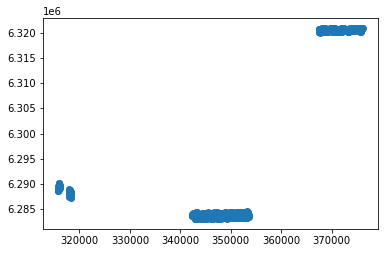

In [38]:
gdf.plot()

In [40]:
src_sdb = rasterio.open(bathmos)
# Sample the raster at every point location and store values in DataFrame
#gdf['SDB'] = [x for x in src_sdb.sample(points)]
gdf['SDB'] = [x[0] for x in src_sdb.sample(points)]

In [44]:
src_lid = rasterio.open(outmos)
gdf['lidar'] = [x[0] for x in src_lid.sample(points)]

In [45]:
gdf.head()

,x,y,geometry,SDB,lidar
0,318311.481221,6.288368e+06,POINT (318311.481 6288368.147),-19.574816,-20.389999
1,367451.215474,6.320372e+06,POINT (367451.215 6320372.127),-16.727447,-22.760000
2,370652.201422,6.320205e+06,POINT (370652.201 6320204.986),-16.843718,-19.370001
3,373725.236917,6.320910e+06,POINT (373725.237 6320910.028),-13.887700,-14.150000
4,368416.768254,6.320247e+06,POINT (368416.768 6320246.555),-18.294212,-21.760000


In [48]:
subdf = gdf[gdf['SDB'].notna()]
subdf = subdf[subdf['lidar'].notna()]

In [49]:
subdf.head()

,x,y,geometry,SDB,lidar
0,318311.481221,6.288368e+06,POINT (318311.481 6288368.147),-19.574816,-20.389999
1,367451.215474,6.320372e+06,POINT (367451.215 6320372.127),-16.727447,-22.760000
2,370652.201422,6.320205e+06,POINT (370652.201 6320204.986),-16.843718,-19.370001
3,373725.236917,6.320910e+06,POINT (373725.237 6320910.028),-13.887700,-14.150000
4,368416.768254,6.320247e+06,POINT (368416.768 6320246.555),-18.294212,-21.760000


In [51]:
x, y = subdf['SDB'].values, subdf['lidar'].values

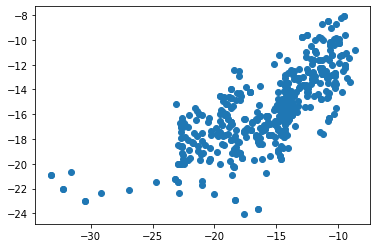

In [56]:
plt.scatter(y, x)
plt.show()

In [58]:
!git reset --soft HEAD~1